In [2]:
import numpy as np
import scipy.interpolate as inp
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import scipy as spy
import numpy as np
from scipy import integrate
from CoolProp.CoolProp import PropsSI
from scipy.misc import derivative

# interpolation merkel diagram

In [6]:
df = pd.read_excel("data from merkel.xlsx", sheet_name="cacl2")
df.head()

,x00,i00,x20,i20,x40,i40,x60,i60
0,-0.000086,0.596114,0.001170,19.247905,0.001636,39.089545,0.001706,58.732457
1,0.004671,-0.193761,0.003151,18.753445,0.004807,38.199204,0.006858,57.446863
2,0.008635,-0.984266,0.004340,18.456770,0.009959,37.012817,0.010028,56.556522
3,0.014185,-1.971925,0.005926,18.160409,0.013526,36.122790,0.012406,55.963171
4,0.022113,-3.354521,0.007908,17.765157,0.015904,35.529440,0.015577,55.271243


In [7]:
# transfer columns of dataframe to list
x_60 = df["x60"].tolist()
y_60 = df["i60"].tolist()
y_40 = df["i40"].dropna().tolist()
x_40 = df["x40"].dropna().tolist()
y_20 = df["i20"].dropna().tolist()
x_20 = df["x20"].dropna().tolist()
y_00 = df["i00"].dropna().tolist()
x_00 = df["x00"].dropna().tolist()

In [8]:
# fit data into polynorm
z_60 = np.polyfit(x_60, y_60, 5, full=True)
z_40 = np.polyfit(x_40, y_40, 5, full=True)
z_20 = np.polyfit(x_20, y_20, 5, full=True)
z_00 = np.polyfit(x_00, y_00, 5, full=True)

In [9]:
# convert polynorm to callable functions
p_60 = np.poly1d(z_60[0])
p_40 = np.poly1d(z_40[0])
p_20 = np.poly1d(z_20[0])
p_00 = np.poly1d(z_00[0])

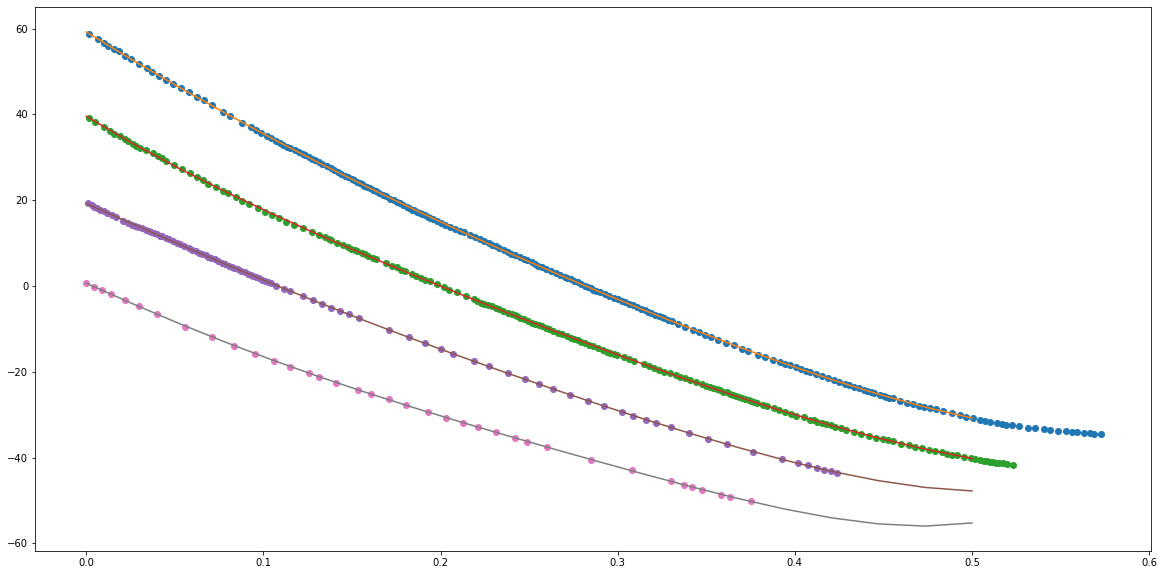

In [10]:
# plot
x_60_new = np.linspace(0, 0.5, num = 20, endpoint = True)
y_60_new = p_60(x_60_new)

x_40_new = np.linspace(0, 0.5, num = 20, endpoint = True)
y_40_new = p_40(x_40_new)

x_20_new = np.linspace(0, 0.5, num = 20, endpoint = True)
y_20_new = p_20(x_20_new)

x_00_new = np.linspace(0, 0.5, num = 20, endpoint = True)
y_00_new = p_00(x_00_new)

plt.figure(figsize = (20,10))

plt.plot(x_60, y_60,'o', x_60_new, y_60_new)
plt.plot(x_40, y_40,'o', x_40_new, y_40_new)
plt.plot(x_20, y_20,'o', x_20_new, y_20_new)
plt.plot(x_00, y_00,'o', x_00_new, y_00_new)

plt.show
plt.savefig('polyfit.png', dpi=300, transparent=True)

In [11]:
dict_integ_func = {'t0':p_00, 't20':p_20, 't40':p_40, 't60':p_60}

# build functions for calculation

### Step1: function of enthaltpy for solution regardless enthalpy of dilution

In [12]:
# define function of water heat capacity
para_wa = [88.7891, -120.1958, -16.9264, 52.4654, 0.10826, 0.46988]
para_ca = [1.63799, -1.69002, 1.05124, 0.0, 0.0, 58.5225, -105.6343, 47.7948]
cp_w = lambda theta: para_wa[0] + para_wa[1]*theta**0.02 + para_wa[2]*theta**0.04 + para_wa[3]*theta**0.06 + para_wa[4]*theta**1.8 + para_wa[5]*theta**8

In [13]:
# heat capacity of solution
f1 = lambda xi: para_ca[0] * xi + para_ca[1] * xi ** 2 + para_ca[2] * xi **3
f2 = lambda theta: para_ca[-3]*theta**0.02 + para_ca[-2]*theta**0.04 + para_ca[-1]*theta**0.06
cp_T = lambda theta, xi: cp_w(theta) * (1 - f1(xi) * f2(theta))
cp_T(xi=0.2, theta = 293.15/228-1)

3.103314140827976

In [13]:
PropsSI('C','T',293.15,'Q',0, 'IF97::Water')*0.8516

3564.0332811881485

In [12]:
cp_T(xi=0.1097, theta=298.15/228-1)

3.5295905045530307

In [14]:
# define function to enable integration of T
def get_cp(xi):
    cp_T_ = lambda T: cp_T(theta=T/228-1, xi=xi)
    return cp_T_

In [15]:
# final function to get h from T and x (enthalpy of dilution excluded...)
def get_h(xi, T0, T):
    h = integrate.quad(get_cp(xi), T0, T)
    return h

### Step 2: enthalpy of dilution

In [16]:
para_ca_h_d = [0.855, -1.965, -2.265, 0.8, -955.690, 3011.974]

In [17]:
delta_h_d0 = lambda theta: para_ca_h_d[4] + para_ca_h_d[5] * theta

In [18]:
zeta = lambda xi: xi/(para_ca_h_d[3] - xi)

In [19]:
delta_h_d = lambda xi, T: delta_h_d0(theta=T/647) * (1+(zeta(xi)/para_ca_h_d[0]) ** para_ca_h_d[1]) ** para_ca_h_d[2]

In [20]:
# calculate the mean value of max and min
def get_h_dil_avg(T, xi0, xi):
    return (delta_h_d(T=T, xi = xi0) + delta_h_d(T=T, xi = xi))/2

In [21]:
# calculate the mean value from integration by x
def get_h_dil_integral_to_x(T, xi0, xi):
    delta_h_d_ = lambda x: delta_h_d(T=T, xi=x)
    h_dil = integrate.quad(delta_h_d_, xi0, xi)
    return abs(h_dil[0]/abs(xi0-xi)), h_dil[0]

In [22]:
# calculate the mean value from integration by water mass 
def get_h_dil_integral_to_water(T, xi0, xi):
    delta_h_d_ = lambda x: delta_h_d(T=T, xi=x)*(-x**-2)
    h_dil = integrate.quad(delta_h_d_, xi0, xi)
    return h_dil

In [23]:
x_for_dilution = np.linspace(0.01, 0.5, num = 20, endpoint = False)

y_water = [PropsSI('H','T',288.15,'Q',0, 'IF97::Water')/1000 for i in x_for_dilution]

# enthalpy of dilution without integration
y_for_dilution = [delta_h_d(i, 288.15) for i in x_for_dilution]
y_for_dilution2 = [delta_h_d(i, 298.15) for i in x_for_dilution]
y_for_dilution3 = [delta_h_d(i, 308.15) for i in x_for_dilution]

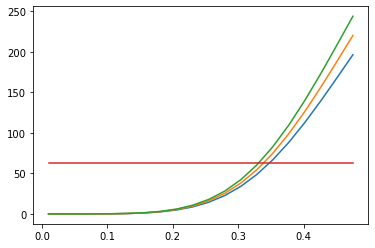

In [24]:
plt.plot(x_for_dilution, y_for_dilution, x_for_dilution, y_for_dilution2,  x_for_dilution, y_for_dilution3, x_for_dilution, y_water)

### Step 3 calculation of delta Q

In [25]:
def get_Q(T_ref, T_2, T_1, xi1, xi2):
    # T_ref reference temperature
    # T_2 temperature of solution 2
    # T_1 temperature of solution 1
    delta_h_integral = get_h(xi=xi2, T0=T_ref, T=T_2)[0] - xi2 / xi1 * get_h(xi=xi1, T0=T_ref, T=T_1)[0]
    dt_h_dilution = (1 - xi2 / xi1)*(PropsSI('H','T',T_ref,'Q',0, 'IF97::Water')/1000) - xi2 * get_h_dil_integral_to_water(T=T_ref, xi0=xi1, xi=xi2)[0]
    # dt_h_dilution = (1 - xi2 / xi1)*(PropsSI('H','T',T_ref,'Q',0, 'IF97::Water')/1000 - get_h_dil_integral_to_x(T=T_ref, xi0=xi1, xi=xi2)[0])
    Q_0 = delta_h_integral + dt_h_dilution
    return Q_0, delta_h_integral, dt_h_dilution

In [26]:
def get_Q_interp(T_1, T_2, xi1, xi2):
    str_temp1 = 't'+ str(int(T_1-273.15))
    str_temp2 = 't'+ str(int(T_2-273.15))
    try:
        selected_func1 = dict_integ_func[str_temp1]
        selected_func2 = dict_integ_func[str_temp2]
    except:
        print("the temperature of interpolation could only be 0, 20, 40, 60")
    delta_Q = (selected_func2(xi2) - xi2/xi1*selected_func1(xi1))*4.184
    return delta_Q

In [27]:
# test get_Q
print(get_Q(T_ref=288.15, T_2=293.15, T_1 = 293.15, xi1=0.3, xi2=0.01))

# test interpolation function
print(dict_integ_func["t0"](0.1))

# test interpolation function for Q
print(get_Q_interp(T_1=293.15, T_2=293.15, xi1=0.3, xi2=0.01))

(80.5886214739898, 19.971440105487588, 60.61718136850221)
-16.480841866896895
76.83086901594275


# Validation

In [28]:
def get_deviation(T_1, T_2, xi1, xi2, T_ref = 278.15):
    ans1 = get_Q(T_ref=T_ref, T_1=T_1, T_2=T_2, xi1=xi1, xi2=xi2)[0]
    ans_ref = get_Q_interp(T_1=T_1, T_2=T_2, xi1=xi1, xi2=xi2)
    
    dev = (ans1 - ans_ref)/ans_ref
    return dev

In [29]:
get_deviation(313.15, 293.15, 0.35, 0.005)

0.03913705863456351

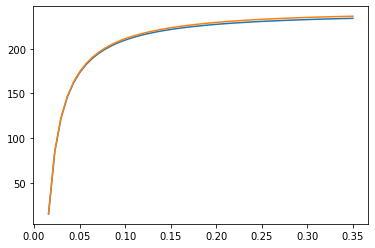

In [30]:
# test diagramm
x_Q_validation = np.linspace(0.016, 0.35, num = 50, endpoint = True)

y_Q_interp_20 = [get_Q_interp(T_1=333.15, T_2 = 333.15 , xi2= 0.015, xi1=i) for i in x_Q_validation]

y_Q_function_20_0 = [get_Q(T_ref=278.15, T_2=333.15, T_1 = 333.15, xi1=i, xi2=0.015)[0] for i in x_Q_validation]

# enthalpy difference term and dilution term
# y_Q_function_20_1 = [get_Q(T_ref=278.15, T_2=333.15, T_1 = 333.15, xi1=i, xi2=0.015)[1] for i in x_Q_validation]
# y_Q_function_20_2 = [get_Q(T_ref=278.15, T_2=333.15, T_1 = 333.15, xi1=i, xi2=0.015)[2] for i in x_Q_validation]

plt.plot(x_Q_validation, y_Q_interp_20, x_Q_validation, y_Q_function_20_0)#, x_Q_validation, y_Q_function_20_1, x_Q_validation, y_Q_function_20_2)

### plot diagram for validation

In [55]:
xi2_end = 0.3

x_Q_validation = np.linspace(xi2_end + 0.0001, 0.35, num = 50, endpoint = True)

# y_Q_interp_0 = [get_Q_interp(T_1=273.15, T_2 = 273.15 , xi2= xi2_end, xi1=i) for i in x_Q_validation]
# y_Q_function_0_0 = [get_Q(T_ref=278.15, T_2=273.15, T_1 = 273.15, xi1=i, xi2=xi2_end)[0] for i in x_Q_validation]

# y_Q_interp_20 = [get_Q_interp(T_1=293.15, T_2 = 293.15 , xi2= xi2_end, xi1=i) for i in x_Q_validation]
# y_Q_function_20_0 = [get_Q(T_ref=278.15, T_2=293.15, T_1 = 293.15, xi1=i, xi2=xi2_end)[0] for i in x_Q_validation]

y_Q_interp_40 = [get_Q_interp(T_1=313.15, T_2 = 313.15 , xi2= xi2_end, xi1=i) for i in x_Q_validation]
y_Q_function_40_0 = [get_Q(T_ref=278.15, T_2=313.15, T_1 = 313.15, xi1=i, xi2=xi2_end)[0] for i in x_Q_validation]

# y_Q_interp_60 = [get_Q_interp(T_1=333.15, T_2 = 333.15 , xi2= xi2_end, xi1=i) for i in x_Q_validation]
# y_Q_function_60_0 = [get_Q(T_ref=278.15, T_2=333.15, T_1 = 333.15, xi1=i, xi2=xi2_end)[0] for i in x_Q_validation]

y_Q_interp_60_2 = [get_Q_interp(T_1=333.15, T_2 = 333.15 , xi2= xi2_end, xi1=i) for i in x_Q_validation]
y_Q_function_60_0_2 = [get_Q(T_ref=278.15, T_2=333.15, T_1 = 333.15, xi1=i, xi2=xi2_end)[0] for i in x_Q_validation]

# y_Q_interp_60_40 = [get_Q_interp(T_1=313.15, T_2 = 333.15 , xi2= xi2_end, xi1=i) for i in x_Q_validation]
# y_Q_function_60_40_0 = [get_Q(T_ref=278.15, T_2=333.15, T_1 = 313.15, xi1=i, xi2=xi2_end)[0] for i in x_Q_validation]

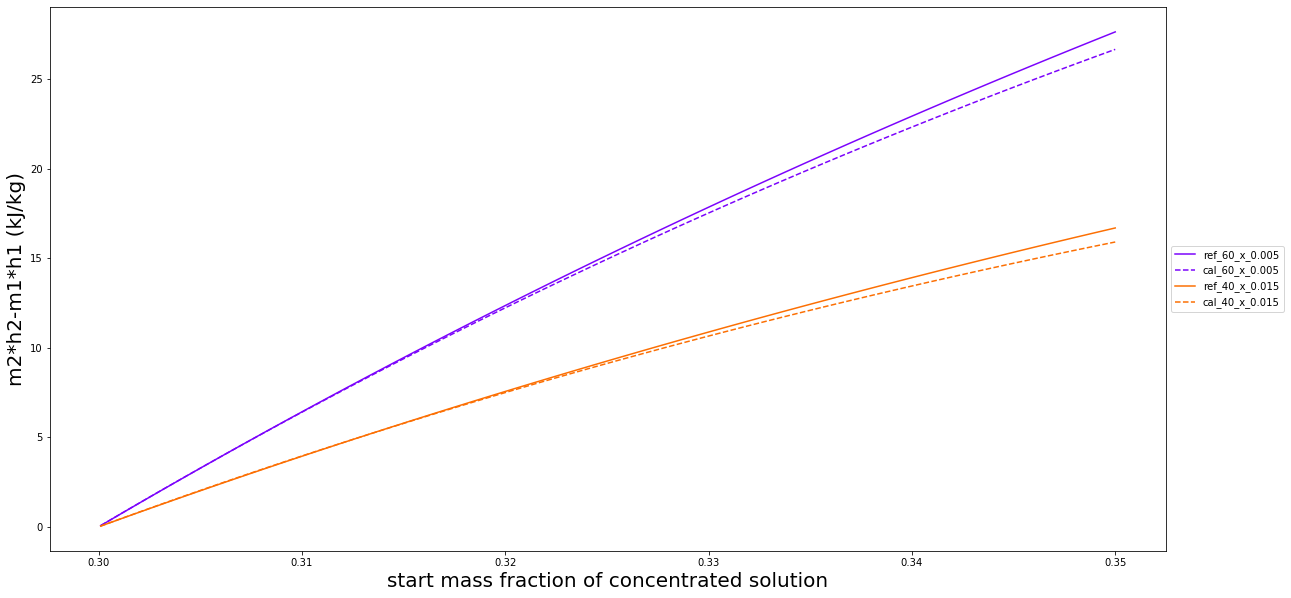

In [56]:
fig, ax = plt.subplots(figsize=(20,10))

# ax.plot(x_Q_validation, y_Q_interp_60_40, label = "ref_60_40_x_0.015", color = "#0f03fc")
# ax.plot(x_Q_validation, y_Q_function_60_40_0, label = "cal_60_40_x_0.015", color = "#0f03fc", linestyle='dashed')

ax.plot(x_Q_validation, y_Q_interp_60_2, label = "ref_60_x_0.005", color = "#7b03fc")
ax.plot(x_Q_validation, y_Q_function_60_0_2, label = "cal_60_x_0.005", color = "#7b03fc", linestyle='dashed')

# ax.plot(x_Q_validation, y_Q_interp_60, label = "ref_60_x_0.015", color = "red")
# ax.plot(x_Q_validation, y_Q_function_60_0, label = "cal_60_x_0.015", color = "red", linestyle='dashed')

ax.plot(x_Q_validation, y_Q_interp_40, label = "ref_40_x_0.015", color = "#fc6f03")
ax.plot(x_Q_validation, y_Q_function_40_0, label = "cal_40_x_0.015", color = "#fc6f03", linestyle='dashed')

# ax.plot(x_Q_validation, y_Q_interp_20, label = "ref_20_x_0.015", color = "#fcce03")
# ax.plot(x_Q_validation, y_Q_function_20_0, label = "cal_20_x_0.015", color = "#fcce03", linestyle='dashed')

# ax.plot(x_Q_validation, y_Q_interp_0, label = "ref_0_x_0.015", color = "#03fc6f")
# ax.plot(x_Q_validation, y_Q_function_0_0, label = "cal_0_x_0.015", color = "#03fc6f", linestyle='dashed')

ax.set_xlabel("start mass fraction of concentrated solution", size = 20)
ax.set_ylabel("m2*h2-m1*h1 (kJ/kg)", size = 20)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('validation_interp_integ_CaCl2.png', dpi=300, transparent=True)

In [34]:
def RMSRE(ref, sim):
    ref, sim = np.array(ref), np.array(sim)
    result = np.sqrt((((ref - sim)/ref) ** 2).mean())
    
    return result

In [42]:
RMSRE(y_Q_interp_60_40, y_Q_function_60_40_0)

0.008520444155276136

### validation: get h from cp integral

In [30]:
x_cords_cp = np.linspace(0.5, 0.05, 50)

In [31]:
# y_cords0_cp = [get_h(T0 = 273.16, T=283.15, xi=i)[0] for i in x_cords_cp ]
# y_cords1_cp = [get_h(T0 = 273.16, T=288.15, xi=i)[0] for i in x_cords_cp ]
y_cords2_cp = [get_h(T0 = 273.16, T=293.15, xi=i)[0] for i in x_cords_cp ]
# y_cords3_cp = [get_h(T0 = 273.16, T=298.15, xi=i)[0] for i in x_cords_cp ]
# y_cords4_cp = [get_h(T0 = 273.16, T=303.15, xi=i)[0] for i in x_cords_cp ]
# y_cords5_cp = [get_h(T0 = 273.16, T=308.15, xi=i)[0] for i in x_cords_cp ]
y_cords6_cp = [get_h(T0 = 273.16, T=313.15, xi=i)[0] for i in x_cords_cp ]
# y_cords7_cp = [get_h(T0 = 273.16, T=318.15, xi=i)[0] for i in x_cords_cp ]
# y_cords8_cp = [get_h(T0 = 273.16, T=323.15, xi=i)[0] for i in x_cords_cp ]
# y_cords9_cp = [get_h(T0 = 273.16, T=328.15, xi=i)[0] for i in x_cords_cp ]
y_cords10_cp = [get_h(T0 = 273.16, T=333.15, xi=i)[0] for i in x_cords_cp ]

y_ref_20 = [p_20(i) for i in x_cords_cp ]
y_ref_40 = [p_40(i) for i in x_cords_cp ]
y_ref_60 = [p_60(i) for i in x_cords_cp ]

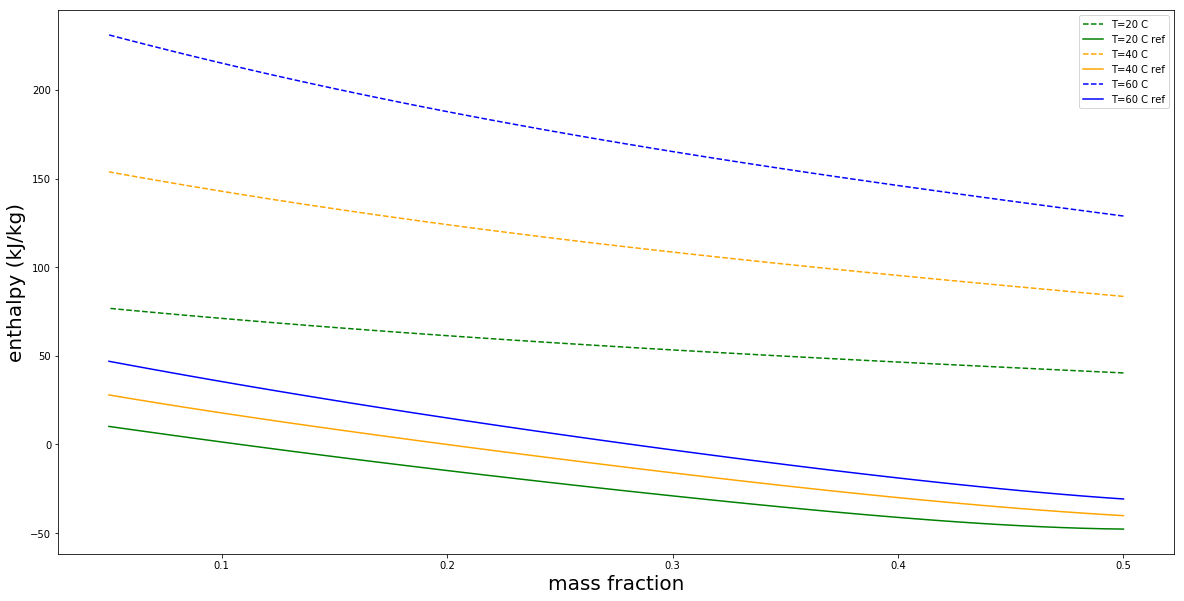

In [32]:
fig1, ax1 = plt.subplots(figsize=(20,10))

# ax1.plot(x_cords_cp, y_cords0_cp, label = "T=10 C")
# ax1.plot(x_cords_cp, y_cords1_cp, label = "T=15 C")
ax1.plot(x_cords_cp, y_cords2_cp, label = "T=20 C", color = "green", linestyle = "dashed")
ax1.plot(x_cords_cp, y_ref_20, label = "T=20 C ref", color = "green")
# ax1.plot(x_cords_cp, y_cords3_cp, label = "T=25 C")
# ax1.plot(x_cords_cp, y_cords4_cp, label = "T=30 C")
# ax1.plot(x_cords_cp, y_cords5_cp, label = "T=35 C")
ax1.plot(x_cords_cp, y_cords6_cp, label = "T=40 C", color = "orange", linestyle = "dashed")
ax1.plot(x_cords_cp, y_ref_40, label = "T=40 C ref", color = "orange")
# ax1.plot(x_cords_cp, y_cords7_cp, label = "T=45 C")
# ax1.plot(x_cords_cp, y_cords8_cp, label = "T=50 C")
# ax1.plot(x_cords_cp, y_cords9_cp, label = "T=55 C")
ax1.plot(x_cords_cp, y_cords10_cp, label = "T=60 C", color = "blue", linestyle = "dashed")
ax1.plot(x_cords_cp, y_ref_60, label = "T=60 C ref", color = "blue")

ax1.set_xlabel("mass fraction", size = 20)
ax1.set_ylabel("enthalpy (kJ/kg)", size = 20)

ax1.legend()
plt.savefig('enthalpy_xi_from_cp.png', dpi=300, transparent=True)
plt.show()